In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install seaborn
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
import glacierml as gl
tf.random.set_seed(42)

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

currently running tensorflow version: 2.8.0


# ML Analysis

In [2]:
# select dataset to analyze

selected_dataset = 'df6'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
    
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df2 = df2.drop(['RGIId', 'region'], axis = 1)
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
    
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df3 = df3.drop(['RGIId', 'region'], axis = 1)
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = 'df3'
    
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df4 = df4.drop(['RGIId', 'region'], axis = 1)
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = 'df4'

if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off',
    )
    df5 = df5.drop(['RGIId', 'region'], axis = 1)
    df5['Zdelta'] = df5['Zmax'] - df5['Zmin']
    module = 'sm5'
    res = 'sr5'
    dataset = df5
    dataset.name = 'df5'
    
if selected_dataset == 'df6':
    df6 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 25
    )
    df6 = df6.drop(['RGIId','region'], axis = 1)
    df6['Zdelta'] = df6['Zmax'] - df6['Zmin']
    module = 'sm6'
    res = 'sr6'
    dataset = df6
    dataset.name = 'df6'
    
    
if selected_dataset == 'df7':
    df7 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 75
    )
    df7 = df7.drop(['RGIId','region'], axis = 1)
    df7['Zdelta'] = df7['Zmax'] - df7['Zmin']
    module = 'sm7'
    res = 'sr7'
    dataset = df7
    dataset.name = 'df7'
dataset    

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness,Zdelta
0,67.91500,18.56400,16.9,1204,1526,1698,1.438,98,1941,72.0,494
1,67.91000,18.49600,15.9,1207,1443,2070,3.696,282,3954,84.0,863
2,67.90300,18.56900,13.2,1143,1414,1797,3.405,102,3636,99.0,654
3,41.41401,-122.21133,21.5,3033,3492,4180,1.291,332,3168,20.0,1147
4,48.75239,-113.72706,17.2,1961,2039,2398,1.018,23,1560,64.0,437
...,...,...,...,...,...,...,...,...,...,...,...
193,77.97140,14.06910,10.1,195,336,521,6.737,56,3780,65.0,326
194,-3.05715,37.35070,9.9,5663,5771,5794,0.616,355,905,23.0,131
195,77.02720,15.48540,18.8,323,422,587,0.418,144,1084,27.0,264
196,78.87100,12.16140,13.8,123,388,684,5.016,350,4111,76.0,561


In [ ]:
df6['Thickness'].mean()

In [ ]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))
print('1/10 inputs = ' + str(0.1 * total_inputs))
print('1/2 inputs = ' + str(0.5 * total_inputs))
non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 4
layer_2 = 4


total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

In [3]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()

for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)

deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains(selected_dataset)) 
#     &
#     (deviations['layer architecture'] == '10-5')
    &
    (deviations['learning rate'] == 0.01)
#     &
#     (deviations['epochs'] == 999)
    &
    (deviations['dropout'] == 1)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
        'layer architecture',
        'test - train',
        'epochs',
        'test mae avg', 
        'train mae avg',
        'test predicted thickness std dev',
        'layer architecture',
        'learning rate',
        'df',
        'layer architecture'
    ]
)
deviations['paramater ratio'] = deviations['trained parameters'] / deviations['total inputs']
deviations[deviations['layer architecture'] == '3-2']

100%|██████████| 3066/3066 [00:00<00:00, 127228.38it/s]


,layer architecture,total parameters,trained parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev,test - train,paramater ratio
18,3-2,65,44,1980,df6,1,0.01,0.2,2000,17.798842,17.642393,4.886297,3.093484,4.991719,2.831735,0.156449,0.022222


In [ ]:
deviations.sort_values('paramater ratio')

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
# plt.suptitle(
#     'Volume estimates using dataset coregistration ' + training_module +
#     ', layer architecture ' + arch +
#     ', learning rate: ' + str(top_learning_rate)
#              , fontsize=18, y=1
#             )
fig.patch.set_facecolor('w')
plt.scatter(
    deviations['paramater ratio'],
    deviations['test mae avg']
)
plt.xscale('log')
plt.ylabel('Bootstrap test MAE')
plt.xlabel('Trainable parameters / total inputs')

Please select index from deviations table to inspect further
18
3-2
0.01
2000
1
3-2
0.01
2000
1
figs/sm6/
saved_results/sr6/sr_3-2/


25it [00:06,  3.83it/s]


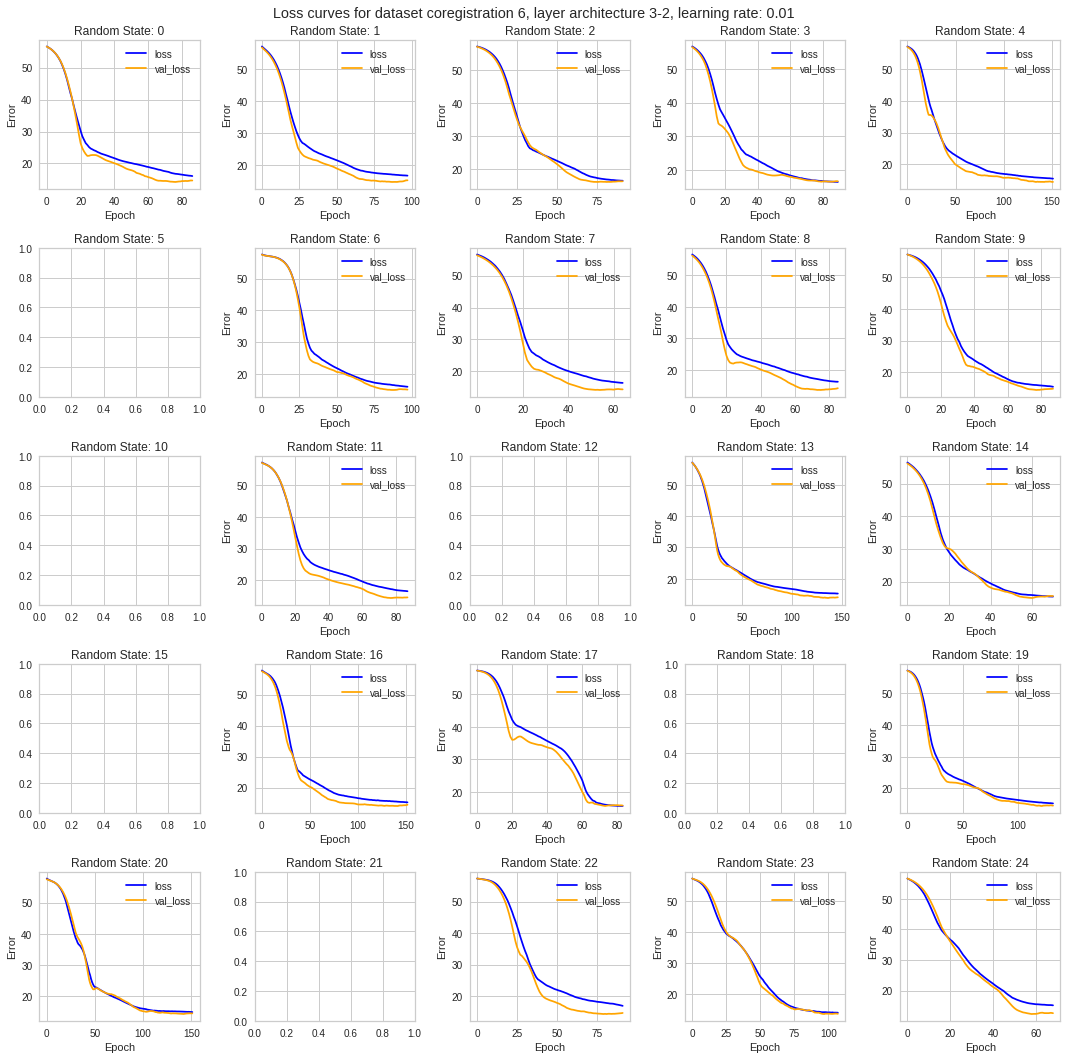

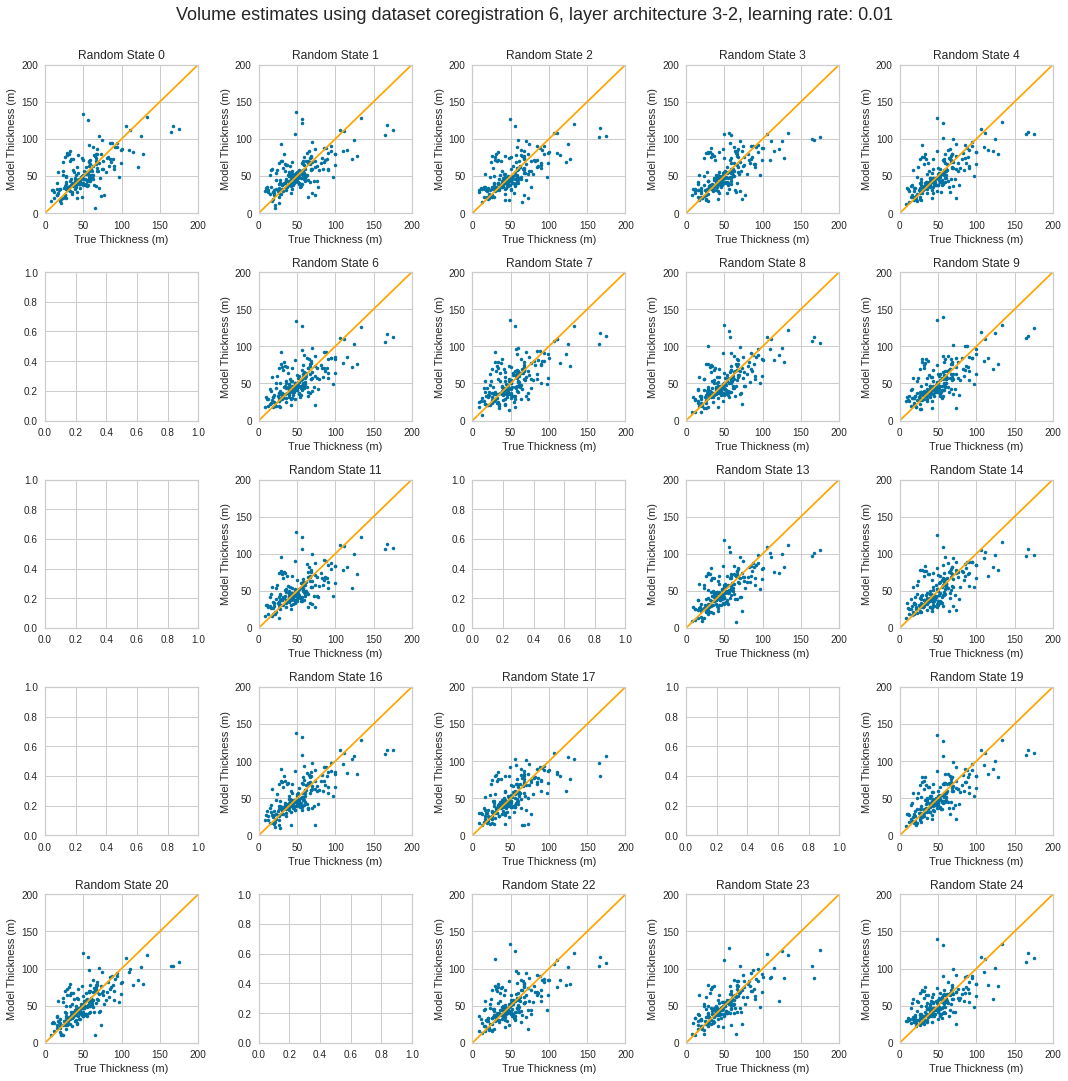

In [15]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
training_module = deviations['df'].loc[selection][2:4]
dataset.name = deviations['df'].loc[selection]

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)
fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir_1 = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir_1)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
fig.suptitle('Loss curves for dataset coregistration ' + training_module +
             ', layer architecture ' + 
             arch + ', learning rate: ' + str(top_learning_rate) 
             )


for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_name)
    
    ax.set_title('Random State: ' + str(rs))
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
        gl.plot_loss(dnn_history[model_name])
    
file_name_1 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)

file_name_2 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.svg'
)

plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)



dnn_model = {}
rootdir_2 = 'saved_models/' + module + '/sm_' + arch + '/'

train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using dataset coregistration ' + training_module +
    ', layer architecture ' + arch +
    ', learning rate: ' + str(top_learning_rate)
             , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_history = (
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_history_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )  
    
    model_path = (
        rootdir_2 + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    dnn_history[model_name] = pd.read_csv(rootdir_1 + model_history)
    
    if abs((
        dnn_history[model_name]['loss'].iloc[-1]
    ) - dnn_history[model_name]['val_loss'].iloc[-1]) >= 3:
        pass
    else:
    
        y = dnn_model[model_name].predict(features, verbose = 0)
        plt.plot(labels,y,'.')
        plt.plot(
            (0,400),
            (0,400),
            '-',
            color = 'orange'    
        )
        plt.xlabel('True Thickness (m)')
        plt.ylabel('Model Thickness (m)')
        ax.set_title('Random State ' +str(rs))
        plt.xlim((0,200))
        plt.ylim((0,200))
# plt.tight_layout()

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)
file_name_1 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)
file_name_2 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.svg'
)
plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)

# Predictions Analysis

In [4]:
predictions = gl.predictions_finder()
predictions = predictions.reset_index()
predictions = predictions.drop('index', axis = 1)
predictions = predictions[predictions['learning rate'] == '0.01']
predictions.sort_values('predicted volume')

100%|██████████| 3066/3066 [02:20<00:00, 21.89it/s]


,architecture,learning rate,coregistration,predicted volume,std dev
101,15-2,0.01,6,73.883447,29.044112
96,9-3,0.01,6,74.873912,48.081085
18,19-2,0.01,6,76.243682,31.664553
107,13-2,0.01,6,77.295980,33.465405
87,16-3,0.01,6,79.057035,27.817842
...,...,...,...,...,...
140,15-13,0.01,6,119.811682,49.770994
122,16-10,0.01,6,120.192251,33.707204
58,7-6,0.01,6,120.548831,55.450949
130,16-15,0.01,6,120.637529,46.206573


In [6]:
predictions = predictions[predictions['learning rate'] == '0.01']
predictions[predictions['architecture'] == '16-10']

,architecture,learning rate,coregistration,predicted volume,std dev
122,16-10,0.01,6,120.192251,33.707204


In [ ]:
print('mean predicted volume: ' + str(predictions['predicted volume'].mean()))
print('median predicted volume: ' + str(predictions['predicted volume'].median()))
print('predicted volume std dev: ' + str(predictions['predicted volume'].std()))
print('mean predicted std dev std dev: ' + str(predictions['std dev'].median()))

In [ ]:
print(predictions['architecture'][predictions['architecture'] == '3-2'].values)

In [7]:
idx = 122
training_module = predictions['coregistration'].iloc[idx]
architecture = '_' + predictions['architecture'].iloc[idx]
learning_rate = predictions['learning rate'].iloc[idx]
epochs = '2000'

df = gl.regional_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
)

df_global = gl.global_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)

df
df_global
gl.glathida_stats_adder(
    df,
#     pth_1 = '/home/simonhans/data/prethicktor/regional_data/raw/',
#     pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/',
#     pth_3 = '/home/simonhans/data/prethicktor/regional_data/training_data/',
)

100%|██████████| 15/15 [00:00<00:00, 341.70it/s]


,vol,Area_RGI_iqr,Area_RGI_mean,Area_RGI_median,Area_RGI_std,Aspect_RGI_iqr,Aspect_RGI_mean,Aspect_RGI_median,Aspect_RGI_std,Lmax_RGI_iqr,Lmax_RGI_mean,Lmax_RGI_median,Lmax_RGI_std,Slope_RGI_iqr,Slope_RGI_mean,Slope_RGI_median,Slope_RGI_std,Zmax_RGI_iqr,Zmax_RGI_mean,Zmax_RGI_median,Zmax_RGI_std,Zmin_RGI_iqr,Zmin_RGI_mean,Zmin_RGI_median,Zmin_RGI_std,architecture,area,dataframe,epochs,h mean f,learning rate,region,tolerance,total variance,volf,mean thickness,voldiff,vol_ratio,Area_GlaThiDa_mean,Aspect_GlaThiDa_mean,Lmax_GlaThiDa_mean,Slope_GlaThiDa_mean,Zmin_GlaThiDa_mean,Zmax_GlaThiDa_mean,Area_GlaThiDa_median,Aspect_GlaThiDa_median,Lmax_GlaThiDa_median,Slope_GlaThiDa_median,Zmin_GlaThiDa_median,Zmax_GlaThiDa_median,Area_GlaThiDa_std,Aspect_GlaThiDa_std,Lmax_GlaThiDa_std,Slope_GlaThiDa_std,Zmin_GlaThiDa_std,Zmax_GlaThiDa_std,ratio trainable
0,16.552863,0.68100,3.199242,0.3130,41.810153,234.00,192.250848,215.0,119.556115,1079.00,1532.236388,744.0,4166.345049,9.00,24.023993,23.00,7.280360,609.00,1816.157186,1797.0,554.464460,626.0,1337.327542,1334.0,500.317301,16-10,86725.053,df6_01,2000,218.0,0.010,01,4.92,1.324379,18.98,190.865993,-2.427137,0.872121,31.746125,178.125000,7208.750000,18.625000,1505.125000,2278.000000,1.8260,206.0,2351.0,21.00,1579.5,2554.0,76.730266,116.309326,13254.758068,5.452924,735.136116,800.062341,0.000295
1,0.745658,0.47200,0.770312,0.1820,4.561523,260.00,153.637072,103.0,127.722660,699.00,907.091806,567.0,1219.842485,9.50,24.509075,24.20,7.448535,678.00,2418.342668,2348.0,575.395510,651.0,2075.797666,1974.0,620.405019,16-10,14524.224,df6_02,2000,72.0,0.010,02,0.27,0.914006,1.06,51.338938,-0.314342,0.703451,2.062406,168.531250,2526.000000,21.178125,2241.687500,3116.937500,1.1850,162.5,2138.0,20.80,2007.5,3011.0,3.074268,120.333387,2238.034517,5.621317,601.644384,608.579182,0.001697
2,17.270820,6.79175,23.110887,1.7665,124.489082,240.00,181.664028,183.0,120.751525,3503.25,4470.662929,1890.0,7968.824606,7.70,15.436148,14.35,6.115374,486.50,1053.961961,1059.0,367.481644,417.0,510.091689,524.5,292.298323,16-10,105108.312,df6_03,2000,270.0,0.010,03,7.35,0.877831,28.33,164.314500,-11.059180,0.609630,1238.533333,259.000000,54630.333333,6.100000,16.000000,1419.666667,999.8610,323.0,71606.0,6.30,0.0,1921.0,1046.519763,92.639085,32082.883332,0.509902,22.627417,819.563434,0.000658
3,4.460442,2.14750,5.514259,0.6570,43.879279,236.00,172.181254,163.0,120.474964,1924.50,2331.581389,1191.0,3683.474811,7.10,17.700000,16.90,5.800160,447.50,1119.713554,1120.0,315.732986,389.0,700.133378,695.0,303.851676,16-10,40888.228,df6_04,2000,210.0,0.010,04,2.23,0.879690,8.61,109.088658,-4.149558,0.518054,1479.180000,30.500000,31318.000000,7.300000,420.500000,1452.000000,1479.1800,30.5,31318.0,7.30,420.5,1452.0,1292.232000,20.500000,1445.000000,3.700000,17.500000,335.000000,0.000270
4,24.501807,1.70625,6.421827,0.3930,79.452633,216.00,179.796711,177.0,114.465345,1608.00,2042.748667,838.0,3956.978654,12.90,20.433266,19.60,9.216535,667.00,1253.893344,1221.0,488.323296,610.0,781.590460,761.0,436.168658,16-10,130054.846,df6_05,2000,175.0,0.010,05,4.07,1.435724,15.69,188.395953,8.811807,1.561619,20.154000,261.000000,8083.000000,11.300000,159.000000,983.000000,20.1540,261.0,8083.0,11.30,159.0,983.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000049
5,1.880277,2.58100,19.505422,0.5690,117.108721,229.00,170.499118,152.0,117.692026,2095.00,3148.227513,987.0,6825.961018,8.60,17.620459,16.70,6.571902,244.50,1295.209877,1267.0,247.578356,267.5,892.552028,936.0,252.231364,16-10,11059.574,df6_06,2000,341.0,0.010,06,0.98,0.250196,3.77,170.013500,-1.889723,0.498747,608.658000,142.000000,28302.666667,11.366667,477.666667,1511.000000,264.5360,117.0,22676.0,7.30,607.0,1762.0,682.150351,41.880783,25153.662349,7.512360,262.994719,499.241425,0.005282
6,4.258307,7.09350,21.027204,1.8740,78.127422,234.00,174.302167,164.0,120.216076,3937.50,4961.415480,2471.0,6949.757330,6.70,14.923901,14.60,5.250610,351.50,740.713932,700.0,278.852043,249.0,260.5

In [ ]:
df_global = df_global.dropna()
df_global

In [ ]:
sum(df_global['volume km3'])

In [ ]:
# compute residuals
residuals = df[[
    'dataframe',
    'vol_ratio',
#     'vol_from_zero',
    'voldiff',
]]

residuals['percent error'] = abs(
   ( 1 - residuals['vol_ratio']) * 100
)
residuals['region'] = residuals['dataframe'].str[4:6]
residuals = residuals.drop('dataframe', axis = 1)
residuals.sort_values('percent error')

In [109]:
predictions = gl.predictions_finder()
predictions = predictions.reset_index()
predictions = predictions.drop('index', axis = 1)

df = pd.DataFrame(columns = {
        'RGIId','0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10',
        '11','12','13','14','15','16','17','18','19','20','21',
        '22','23','24',
})

for index in tqdm(predictions.index):
    idx = index
#     print(idx)

    training_module =  predictions['coregistration'].iloc[idx]
    architecture = predictions['architecture'].iloc[idx]
    learning_rate = predictions['learning rate'].iloc[idx]
    epochs = '2000'
    df_glob = gl.global_predictions_loader(
        training_module = training_module,
        architecture = architecture,
        learning_rate = learning_rate,
        epochs = epochs

    )
    

    df = pd.concat([df,df_glob])

df = df[[
        'RGIId','0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10',
        '11','12','13','14','15','16','17','18','19','20','21',
        '22','23','24',
]]

 43%|████▎     | 70/161 [03:01<06:52,  4.53s/it]


100%|██████████| 3066/3066 [00:01<00:00, 2440.40it/s] 


100%|██████████| 161/161 [12:27<00:00,  4.64s/it]


In [157]:
df

,RGIId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,RGI60-16.00001,14.737699,16.430544,10.038866,27.091085,28.311560,21.521202,20.155740,10.047269,25.787703,23.018960,23.973682,22.179335,17.837370,26.903267,25.106861,3.776082,24.765940,28.319317,16.629345,18.389103,16.802002,30.025060,0.976521,32.158077,25.919853
1,RGI60-16.00002,15.140740,16.290821,10.563762,27.970640,28.743963,21.634990,20.318420,10.356771,26.167948,23.429245,23.964653,22.431498,18.154766,27.374641,24.985897,4.438586,24.682499,28.855154,17.030180,18.858850,16.896284,30.999846,0.976521,32.311348,26.470570
2,RGI60-16.00003,13.887182,18.540787,8.989462,24.963339,28.844223,21.209421,21.000254,8.069089,24.163370,22.832981,22.775002,21.824644,19.552515,25.631393,27.986528,2.668064,26.301113,28.552614,16.200733,18.466812,17.462826,30.479898,0.976521,32.726110,23.345303
3,RGI60-16.00004,18.732471,18.059004,12.320705,27.490343,28.843884,26.222645,22.133993,18.479017,26.048342,23.861380,28.832570,23.719782,21.799843,31.282299,23.907412,12.101339,20.911024,27.602207,16.009518,17.628527,18.473154,33.785477,0.976521,32.437660,31.237720
4,RGI60-16.00005,18.584702,17.356120,11.806168,25.945732,31.416605,25.906647,23.838905,14.693042,24.627954,24.336565,26.075256,23.279217,19.569836,26.648066,25.269855,7.538168,24.368290,29.880547,17.885014,17.130350,17.762909,34.129720,0.976521,32.139170,27.735060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216454,RGI60-19.02748,11.647822,26.211433,24.072119,44.684050,39.988514,39.205204,49.275635,29.696570,38.463620,20.117336,34.005554,15.833321,13.504869,NaN,25.084808,44.501015,25.977610,42.878080,33.425090,36.397930,34.993540,4.550350,41.106037,33.649180,52.348570
216455,RGI60-19.02749,10.515627,37.404970,31.041027,61.554375,40.071770,54.205720,51.370186,58.596123,48.514450,28.267117,47.353275,21.849604,24.152954,NaN,40.266693,60.634390,40.254906,56.199978,45.310500,41.698296,48.844936,12.664095,41.624928,38.679653,70.886925
216456,RGI60-19.02750,23.293030,65.115640,63.776710,108.491980,83.502525,79.595880,72.049255,115.686400,89.316880,57.767643,102.520760,46.988144,44.245327,NaN,66.460700,108.460370,79.417730,104.302536,100.714050,87.003746,65.616230,60.886726,52.016340,71.358440,115.386856
216457,RGI60-19.02751,30.651527,103.410720,62.227680,133.633990,92.271400,100.732666,74.610466,142.387800,108.861720,70.379030,101.152500,71.024734,68.888336,NaN,87.407170,132.160580,73.471420,99.430855,107.890750,101.954500,95.368935,77.359760,80.710470,82.979860,118.196526


In [136]:
thickness = pd.Series(df.groupby('RGIId').mean().mean(axis = 1), name = 'Thickness')

In [192]:
std = df.groupby('RGIId')[
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10',
        '11','12','13','14','15','16','17','18','19','20','21',
        '22','23','24',
]

In [184]:
std.std().std(axis = 1)

RGIId
RGI60-01.00001    0.584545
RGI60-01.00002    0.507837
RGI60-01.00003    0.495777
RGI60-01.00004    0.362865
RGI60-01.00005    0.339475
                    ...   
RGI60-19.02748    1.121398
RGI60-19.02749    1.101135
RGI60-19.02750    1.429788
RGI60-19.02751    1.539754
RGI60-19.02752    1.332551
Length: 216459, dtype: float64

In [185]:
std.mean().std(axis = 1)

RGIId
RGI60-01.00001    0.576725
RGI60-01.00002    0.399060
RGI60-01.00003    0.361699
RGI60-01.00004    0.445510
RGI60-01.00005    0.478713
                    ...   
RGI60-19.02748    0.960225
RGI60-19.02749    1.022700
RGI60-19.02750    1.448089
RGI60-19.02751    1.727183
RGI60-19.02752    1.466254
Length: 216459, dtype: float64

In [186]:
std.std().mean(axis = 1)

RGIId
RGI60-01.00001     7.168716
RGI60-01.00002     5.151734
RGI60-01.00003     4.822341
RGI60-01.00004     5.161949
RGI60-01.00005     5.418095
                    ...    
RGI60-19.02748    13.232627
RGI60-19.02749    14.744742
RGI60-19.02750    21.861159
RGI60-19.02751    25.366911
RGI60-19.02752    20.076076
Length: 216459, dtype: float64

In [193]:
std = pd.Series(std.std().mean(axis = 1), name = 'std')

In [194]:
std

RGIId
RGI60-01.00001     7.168716
RGI60-01.00002     5.151734
RGI60-01.00003     4.822341
RGI60-01.00004     5.161949
RGI60-01.00005     5.418095
                    ...    
RGI60-19.02748    13.232627
RGI60-19.02749    14.744742
RGI60-19.02750    21.861159
RGI60-19.02751    25.366911
RGI60-19.02752    20.076076
Name: std, Length: 216459, dtype: float64

In [195]:
global_thickness = pd.merge(thickness, std, on = 'RGIId')
global_thickness.to_csv('sermeq_mean.csv')
global_thickness

,Thickness,std
RGIId,,
RGI60-01.00001,14.840942,7.168716
RGI60-01.00002,35.318354,5.151734
RGI60-01.00003,33.069360,4.822341
RGI60-01.00004,40.320388,5.161949
RGI60-01.00005,42.106429,5.418095
...,...,...
RGI60-19.02748,26.793757,13.232627
RGI60-19.02749,37.226612,14.744742
RGI60-19.02750,73.351353,21.861159


In [93]:
print(sum(dft['Mean Thickness']))
print(sum(dft['Thickness Std Dev']))

7683070.756291263
155941.09261038323


In [196]:
ref = pd.read_csv('reference_thicknesses/Farinotti_mean_thickness_RGI_ID_2.csv')
ref = ref[[
    'RGIId',
    'Farinotti Mean Thickness'
]]
ref['region'] = ref['RGIId'].str[6:8]
ref = ref.sort_values('RGIId')
ref = ref.dropna()
RGI = gl.RGI_loader()
RGI = RGI[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

# drops = RGI[
# #     (RGI['Aspect'] < 0) | 
#     (RGI['Zmin'] < 0) |
#     (RGI['Zmax'] < 0) |
#     (RGI['Lmax'] < 0) 

# ].index
# RGI = RGI.drop(drops)
RGI['Zdelta'] = RGI['Zmax'] - RGI['Zmin']
# RGI

ref = pd.merge(ref, RGI, on = 'RGIId')

ref = pd.merge(ref, test, 
#                left_index = True, right_index = True)
on = [
    'RGIId'
])
ref = ref.rename(columns = {
    'Thickness':'Edasi Mean Thickness'
})

ref = ref.reset_index()
ref = ref.drop('index', axis = 1)
ref['VE / VF'] = ref['Edasi Mean Thickness'] / ref['Farinotti Mean Thickness']
ref = ref.drop_duplicates()
ref = ref.dropna()
# sum(ref['volume km3'])
ref

,RGIId,Farinotti Mean Thickness,region,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Zdelta,Edasi Mean Thickness,std,VE / VF
0,RGI60-01.00001,21.182035,01,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,789,14.840942,7.168716,0.700638
1,RGI60-01.00002,30.519478,01,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,431,35.318354,5.151734,1.157240
2,RGI60-01.00003,35.518610,01,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,573,33.069360,4.822341,0.931043
3,RGI60-01.00004,53.077263,01,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,1044,40.320388,5.161949,0.759655
4,RGI60-01.00005,47.519207,01,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,823,42.106429,5.418095,0.886093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215482,RGI60-19.02748,12.948014,19,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,200,26.793757,13.232627,2.069333
215483,RGI60-19.02749,22.894110,19,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,500,37.226612,14.744742,1.626034
215484,RGI60-19.02750,60.874610,19,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,1100,73.351353,21.861159,1.204958
215485,RGI60-19.02751,10.053704,19,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,100,90.856097,25.366911,9.037077


In [8]:
ref = pd.read_csv('reference_thicknesses/Farinotti_mean_thickness_RGI_ID_2.csv')
ref = ref[[
    'RGIId',
    'Farinotti Mean Thickness'
]]
ref['region'] = ref['RGIId'].str[6:8]
ref = ref.sort_values('RGIId')
ref = ref.dropna()
RGI = gl.RGI_loader()
RGI = RGI[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

# drops = RGI[
# #     (RGI['Aspect'] < 0) | 
#     (RGI['Zmin'] < 0) |
#     (RGI['Zmax'] < 0) |
#     (RGI['Lmax'] < 0) 

# ].index
# RGI = RGI.drop(drops)
RGI['Zdelta'] = RGI['Zmax'] - RGI['Zmin']
# RGI

ref = pd.merge(ref, RGI, on = 'RGIId')

ref = pd.merge(ref, df_global, 
#                left_index = True, right_index = True)
on = [
    'CenLat','CenLon','Slope','Zmin','Zmed','Zmax','Area','Aspect','Lmax'
])
ref = ref.rename(columns = {
    'avg predicted thickness':'Edasi Mean Thickness'
})

ref = ref.reset_index()
ref = ref.drop('index', axis = 1)
ref['VE / VF'] = ref['Edasi Mean Thickness'] / ref['Farinotti Mean Thickness']
# ref = ref.drop_duplicates()
# ref = ref.dropna()
sum(ref['volume km3'])

108682.39073035234

In [197]:
ref['Farinotti Volume'] = (ref['Farinotti Mean Thickness'] / 1e3 )* ref['Area']
ref['Edasi Volume'] = (ref['Edasi Mean Thickness'] / 1e3)* ref['Area']
ref['Vol Std Dev'] = (ref['std'] / 1e3)* ref['Area']

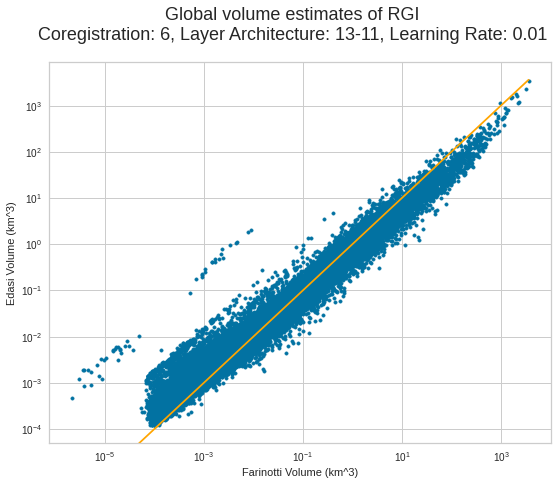

In [198]:
fig, ax = plt.subplots(1,1,figsize=(9, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Global volume estimates of RGI' + 
    '\nCoregistration: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')

plt.scatter(
    x = ref['Farinotti Volume'] ,
    y = ref['Edasi Volume'] ,
    marker = '.',
#     c = ref['norm'],
#     cmap = 'viridis'
)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.plot(
    (0,(ref['Farinotti Volume'].max())),
    (0,ref['Farinotti Volume'].max()),
    '-',
    c = 'orange'

)
# plt.ylim(-20,125)
ax.set_ylabel('Edasi Volume (km^3)')
ax.set_yscale('log')
# plt.xlim(-20,125)
ax.set_xlabel('Farinotti Volume (km^3)')
ax.set_xscale('log')
plt.savefig('figs/scatter/scatter.svg')

In [ ]:
ref = ref.drop_duplicates

In [ ]:
ref

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Area against Volume'+ 
    '\nCoregistration: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')
ref['region'] = ref['region'].astype(int)

plt.scatter(
    x = ref['Edasi Volume'] ,
    y = ref['Area'] ,
    marker = '.',
    c = ref['region'],
    cmap = 'viridis',
    alpha = 0.5
)
# plt.xlim(0,100)
# plt.ylim(0,100)
plt.plot(
    (0,(ref['Farinotti Volume'].max())),
    (0,ref['Farinotti Volume'].max()),
    '-',
    c = 'orange'

)
# plt.ylim(-20,125)
ax.set_ylabel('Area')
ax.set_yscale('log')
# plt.xlim(-20,125)
ax.set_xlabel('Volume')
ax.set_xscale('log')

In [199]:
print(sum(ref['Edasi Volume'] / 1e3))
print(sum(ref['Vol Std Dev'] / 1e3))

90.54894200610966
36.83905163527491


In [ ]:
dfp = pd.DataFrame()
for region in tqdm(ref['region'].unique()):
    dfz = ref[ref['region'] == region]
    dfp = pd.concat([dfp, dfz])
    dfp.loc[dfp.index[-1], 'region'] = region
    dfp.loc[dfp.index[-1],  'max VE / VF'] = dfz['VE / VF'].max()
    dfp.loc[dfp.index[-1], 'min VE / VF'] = dfz['VE / VF'].min()
    dfp.loc[dfp.index[-1], 'mean VE / VF'] = dfz['VE / VF'].mean()
    dfp.loc[dfp.index[-1],'median VE / VF'] = dfz['VE / VF'].median()
dfp = dfp.dropna()
dfp = dfp[[
    'region',
    'max VE / VF',
    'min VE / VF',
    'mean VE / VF',
    'median VE / VF'
]]
dfp

In [ ]:
dfp = pd.DataFrame()
for region in ref['region'].unique():
    dfr = ref[ref['region'] == region]
    region = int(region)
    dfr['reg'] = region
    dfp = dfp.append(dfr)

    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Global volume estimates of RGI'+ 
        '\nTraining Module: ' + predictions['coregistration'].loc[idx] + 
        ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
        ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
        '\nRegion ' + str(region), fontsize=18, y=0.99)
    fig.patch.set_facecolor('w')

    plt.scatter(
        x = dfr['Farinotti Mean Thickness'] * dfr['Area'],
        y = dfr['Edasi Mean Thickness'] * dfr['Area'],
        marker = '.',
#         c = dfp['reg'],
#         cmap = 'viridis', 
#         alpha = 0.5
    #         fill = True
    )
    plt.plot(
        (0,(dfr['Farinotti Mean Thickness'] * dfr['Area']).max()),
        (0,(dfr['Farinotti Mean Thickness'] * dfr['Area']).max()),
        '-',
        c = 'orange'

    )
    # plt.ylim(-20,125)
    ax.set_ylabel('Edasi Volume (km^3)')
    ax.set_yscale('log')
    # plt.xlim(-20,125)
    ax.set_xlabel('Farinotti Volume (km^3)')
    ax.set_xscale('log')

In [ ]:

fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Volume estimates by RGI region' + 
    '\nTraining Module: ' + predictions['coregistration'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')

for n, region_number in tqdm(enumerate(range(1,20,1))):
    if len(str(region_number)) == 1:
        N = 1
        region_number = str(region_number).zfill(N + len(str(region_number)))
    else:
        str(region_number) == str(region_number)
    ax = plt.subplot(5, 4, n + 1)
    dft = ref[ref['region'] == str(region_number)]


    plt.subplots_adjust(hspace=0.5)

    plt.scatter(
        x = dft['Farinotti Mean Thickness'] * dft['Area'],
        y = dft['Edasi Mean Thickness'] * dft['Area'],
        marker = '.',
#         fill = True
    )
    plt.plot(
        (0,(dft['Farinotti Mean Thickness'] * dft['Area']).max()),
        (0,(dft['Farinotti Mean Thickness'] * dft['Area']).max()),
        '-',
        c = 'orange'

    )
    ax.set_title('Region: ' + str(region_number))
    ax.set_ylabel('Edasi Thickness')
    ax.set_xlabel('Farinotti Thickness')
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.tight_layout()

In [ ]:
import cartopy.crs as crs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(20, 20))
dft = ref[
        (ref['VE / VF'] >= 100) &
        (ref['VE / VF'] <= 535)
    ]

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
plt.scatter(
    x = dft['CenLon'], 
    y = dft['CenLat'],
    c = dft['VE / VF'],
    cmap = 'viridis',
    marker = '.', 
    alpha = 1

)
ax.set_title('glaciers of the world')
plt.show()
# plt.savefig('figs/cluster/global_map.png')